In [24]:
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random.seed(42)

### Data Exploration

In [3]:
df=pd.read_csv('data.csv')
print(df.shape)
df.head()

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# No missing values in any row
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [18]:
# the dataset contains users that have experienced both the new and old pages.
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [19]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [20]:
# we drop the second time the instance used the homepage
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [21]:
# the dataset is now cleaner as can see the user experience only one page
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


           conversion_rate  std_deviation  std_error
group                                               
control           0.120173       0.325164   0.000859
treatment         0.118726       0.323466   0.000854


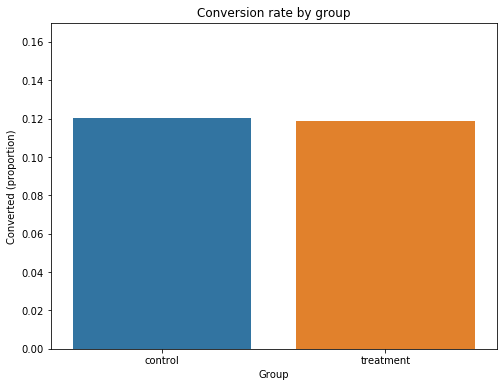

In [48]:
def visualise(df):
    conversion_rates = df.groupby('group')['converted']

    std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
    se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

    conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
    conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


    conversion_rates.style.format('{:.3f}')
    print(conversion_rates)
     
    plt.figure(figsize=(8,6))

    sns.barplot(x=df['group'], y=df['converted'], ci=False)

    plt.ylim(0, 0.17)
    plt.title('Conversion rate by group')
    plt.xlabel('Group')
    plt.ylabel('Converted (proportion)');

visualise(df)    

two designs performed very similarly, the new design performing slightly better average conversion rate.

### Testing the hypothesis

#### null hypothesis Hₒ: p = pₒ Two designs have the same impacts

#### alternative hypothesis Hₐ: p ≠ pₒ Two designs have the different impacts
where p and pₒ are the conversion rate of the new and old design respectively with the confidence level of 95%

null hypothesis means that if null hypothesis is true, it means there is no significant difference between your treatment and control group. Basically, the lower p-value the better.

1. A control group: means old design
2. A treatment group: is the new design

In [42]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
def ZTest(df):
    control_results = df[df['group'] == 'control']['converted']
    treatment_results = df[df['group'] == 'treatment']['converted']
    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    if pval < 0.05:
        print(f'p-value: {pval:.3f}. there is a significant difference between treatment and control group')
    else:
        print(f'p-value: {pval:.3f}. there is no significant difference between treatment and control group')
        
    print('')   
    print(f'z statistic: {z_stat:.2f}')     
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ZTest(df)

p-value: 0.232. there is no significant difference between treatment and control group

z statistic: 1.19
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [0.117, 0.120]


The p-value is above α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that the new design did not perform significantly different compared to the old one.

### Sampling
1. Effect size: this represents the magnitude of difference between averages of test and control group. It is the variance in averages between test and control groups divided by the standard deviation of the control.
2. Power: this refers to the probability of finding a statistical significance in your test. To calculate the sample size, 0.8 is the common value that is being used.

In [16]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print('We’d need at least {0} observations for each group and have a 90% chance to test it is significantly significant'.format(required_n))

We’d need at least 4720 observations for each group and have a 90% chance to test it is significantly significant


In [43]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22) 
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
user_id         9440 non-null int64
timestamp       9440 non-null object
group           9440 non-null object
landing_page    9440 non-null object
converted       9440 non-null int64
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [44]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

           conversion_rate  std_deviation  std_error
group                                               
control           0.123305       0.328787   0.004786
treatment         0.125636       0.331438   0.004824


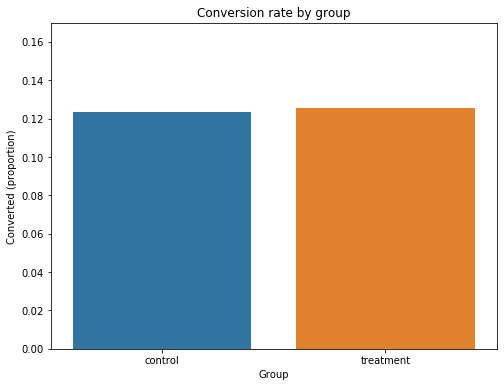

In [49]:
visualise(ab_test) 

In [53]:
ZTest(ab_test)

p-value: 0.732. there is no significant difference between treatment and control group

z statistic: -0.34
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


In [56]:
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
model = smf.ols(formula='converted ~ landing_page + group ', data=ab_test).fit()
aov_table = anova_lm(model, typ=2)
print(np.round(aov_table,4))

                 sum_sq      df         F  PR(>F)
landing_page    13.8153     1.0  126.7468     0.0
group           15.4583     1.0  141.8203     0.0
Residual      1028.7345  9438.0       NaN     NaN
